In [33]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [34]:
epochs = 10
batch_size = 16
margin = 1  # Margin for constrastive loss.

In [35]:
# Load MNIST dataset

(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

In [36]:
x_train, x_val = x_train_val[:30000], x_train_val[30000:]
y_train, y_val = y_train_val[:30000], y_train_val[30000:]
del x_train_val, y_train_val

In [37]:
# (pairs_of_samples, labels)

def make_pairs(x, y):
    
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [38]:
# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [39]:
# Split the training pairs

x_train_1 = pairs_train[:, 0]  
x_train_2 = pairs_train[:, 1]

In [40]:
# Split the validation pairs

x_val_1 = pairs_val[:, 0]  
x_val_2 = pairs_val[:, 1]

In [41]:
# Split the test pairs

x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]

In [42]:
labels_test[6]

1.0

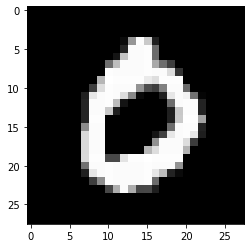

In [43]:
pixels = pairs_test[6,0]
pixels = np.array(pixels, dtype='uint8')
pixels = pixels.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

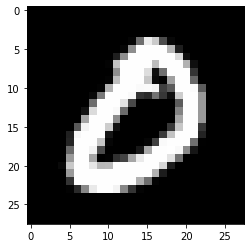

In [44]:
pixels = pairs_test[6,1]
pixels = np.array(pixels, dtype='uint8')
pixels = pixels.reshape((28, 28))
plt.imshow(pixels, cmap='gray')

In [45]:
# Creates a plot of pairs and labels, and prediction if it's test dataset.

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

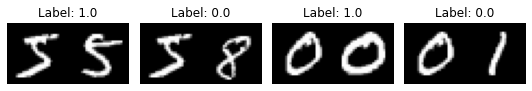

In [46]:
# Some training pairs

visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

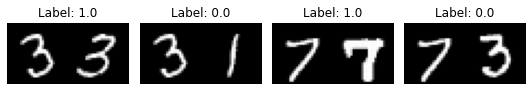

In [47]:
# Some validation pairs

visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

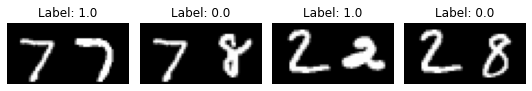

In [48]:
# Some test pairs
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

In [49]:
# Find the Euclidean distance between two vectors.

def euclidean_distance(vects):

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [50]:
input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))

# 2 CNN

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [51]:
def loss(margin=1):

    # Contrastive loss = ( (1-true_value) * square(prediction) + true_value * square( max(margin-prediction, 0) ))
    
    def contrastive_loss(y_true, y_pred):

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [52]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 10)           5318        input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

In [53]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/10
3750/3750 [==============================] - 29s 7ms/step - loss: 0.2517 - accuracy: 0.5089 - val_loss: 0.0759 - val_accuracy: 0.9109
Epoch 2/10
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0746 - accuracy: 0.9022 - val_loss: 0.0298 - val_accuracy: 0.9611
Epoch 3/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0474 - accuracy: 0.9383 - val_loss: 0.0248 - val_accuracy: 0.96820474 - accu
Epoch 4/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0409 - accuracy: 0.9477 - val_loss: 0.0238 - val_accuracy: 0.9701
Epoch 5/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0375 - accuracy: 0.9516 - val_loss: 0.0190 - val_accuracy: 0.9764
Epoch 6/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0335 - accuracy: 0.9570 - val_loss: 0.0183 - val_accuracy: 0.9770
Epoch 7/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.0324 - accuracy: 0.9586 - val_loss: 0.02

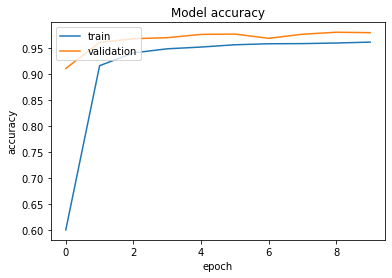

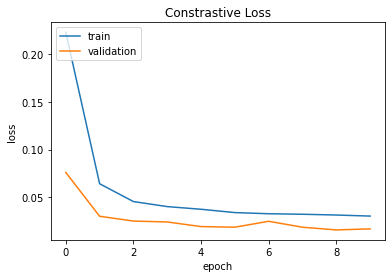

In [57]:
#Plots the given 'metric' from 'history

def plt_metric(history, metric, title, has_valid=True):
    
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [55]:
#Evaluate the model

results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

625/625 [==============================] - 2s 4ms/step - loss: 0.0158 - accuracy: 0.9800
test loss, test acc: [0.01582445204257965, 0.9799500107765198]


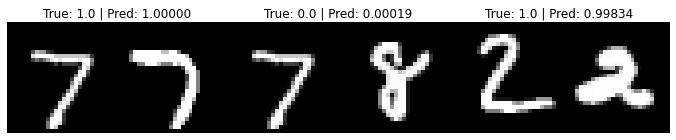

In [56]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)